In [ ]:
file = 'LCALS_energy_calc'
benchmarks = ['LCALS_vol3d_calc', 'LCALS_energy_calc', 'LCALS_pressure_calc']
perf_file = "_perf.csv"
papi_file = "_papi.csv"
pintool_file = "_pintool.csv"

# Hardware Counters

## Metrics
  - **LD_INSTANT**: Load instructions per cycles;
  - **SR_INSTANT**: Store instructions per cycles;
  - **L1_MISS_REL**: L1 cache missess per memory instruction (load or store);
  - **LLC_MISS_REL**: Last Level Cache misses per memory instruction;
  - **NODE_MISS_RELL**: Access to the remote momory node per instruction;


In [ ]:
import pandas as pd
from pandas.io.formats.format import DataFrameRenderer

def get_df(benchmark):
  perf = pd.read_csv(benchmark + perf_file)
  papi = pd.read_csv(benchmark + papi_file)

  df = pd.DataFrame()

  df['OMP_PLACES'], df['OMP_PROC_BIND'] = perf['OMP_PLACES'], perf['OMP_PROC_BIND']
  df['millis'] = round(perf['nanoseconds'] / 1000000, 2)
  df['MEM_INST'] = papi['PAPI_LD_INS'] + papi['PAPI_SR_INS'] 
  df['LD_INSTANT'] = papi['PAPI_LD_INS'] / perf['cycles']
  df['SR_INSTANT'] = papi['PAPI_SR_INS'] / perf['cycles']

  df['L1_MISS_REL'] = perf['L1-dcache-loads-misses'] / df['MEM_INST']
  df['L2_MISS_REL'] = papi['PAPI_L2_DCM'] / df['MEM_INST']
  df['LLC_MISS_REL'] = perf['LLC-load-misses'] / df['MEM_INST']

  df['NODE_MISS_REL'] = (perf['node-loads-misses'] + perf['node-stores-misses']) / df['MEM_INST']
  df['NODE_REL'] = (perf['node-loads'] + perf['node-stores']) / df['MEM_INST']

  return df

In [ ]:
from scipy.stats import hmean
from statistics import mean
means = {}

events = ['millis', 'MEM_INST', 'LD_INSTANT', 'SR_INSTANT', 'L1_MISS_REL', 'L2_MISS_REL', 'LLC_MISS_REL', 'NODE_REL', 'NODE_MISS_REL']
metrics = ['mean', 'median', 'std', 'var']


for bench in benchmarks:
  means[bench] = {}
  for key, grp in get_df(bench).groupby(["OMP_PLACES", "OMP_PROC_BIND"]):
    means[bench][key] = {}
    grp = grp.reset_index()
    means[bench][key]['millis'] = mean(grp['millis'])
    means[bench][key]['MEM_INST'] = mean(grp['MEM_INST'])
    for metric in events[2:]:
      try:
        means[bench][key][metric] = hmean(grp[metric])
      except:
        pass

# pd.DataFrame(means).transpose().to_csv(f'{file}_HW_counters.csv')

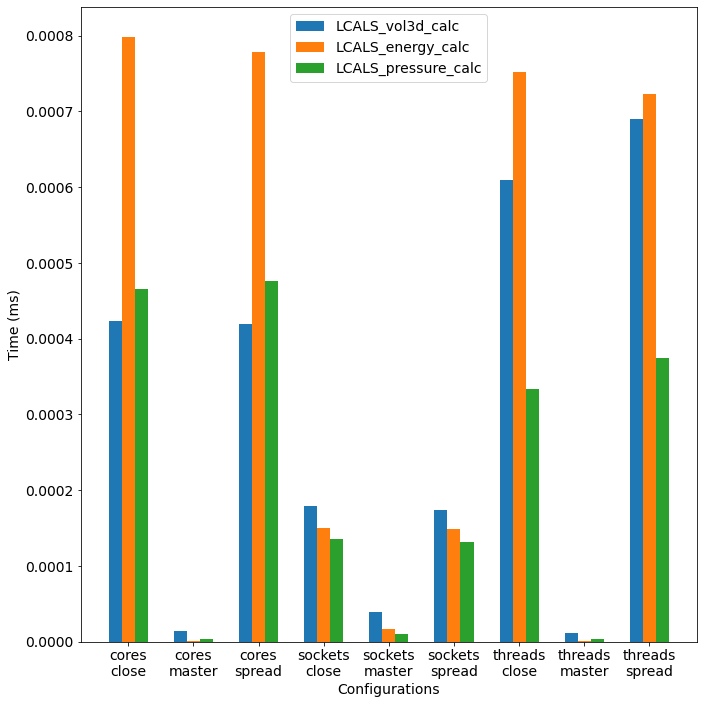

In [ ]:
from matplotlib import pyplot as plt
import numpy as np

plt.rcParams['figure.figsize'] = (10, 10)
plt.rcParams['font.size'] = 14

METRIC = "NODE_MISS_REL"

names = []
for bench in benchmarks:
  for key in means[bench]:
    if key == ('x', 'x'): 
      continue
    names.append('\n'.join(key))
  break

x = np.arange(len(names))
width = 0.20
for i, bench in enumerate(benchmarks):
  values = []
  for key in means[bench]:
    if key == ('x', 'x'): 
      continue
    values.append(means[bench][key][METRIC])
  plt.bar(x + (i * width), values, width, label=bench)


plt.xticks(x + 0.2, names)

plt.xlabel("Configurations")
plt.ylabel("Time (ms)")

# plt.yscale('log')
plt.legend()
plt.tight_layout()
plt.savefig("plot.pdf",format="pdf",bbox_inches="tight")
plt.show()


# Software Counters
